- Notebook modified from https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
- Training only, EDA part not included.
- Image model only, tabular data not used.

Modified from HDJOJO's original notebook with SWIN Transformer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os
import time

from torchvision.io import read_image

tqdm.pandas()

2024-06-05 05:09:48.443491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 05:09:48.443591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 05:09:48.585242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Config():
    IMAGE_SIZE = 224 # Sample: [224, 224]
    BACKBONE = "vit-base-patch16-224-in21k"
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10 # Sample: 96
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 6 # Sample: 12
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    
    # Added variables
    NUM_FOLDS = 5
    VALID_FOLD = 0  # Fold of validation data
        
CONFIG = Config()

In [3]:
import torch 
import torch.nn as nn
from transformers import AutoImageProcessor, ViTModel

class ViTForRegression(nn.Module):
    def __init__(self, model_name, num_outputs, dropout_rate=0.2):
        super(ViTForRegression, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.vit.config.hidden_size, num_outputs)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        last_hidden_state = outputs.last_hidden_state
        # Use the [CLS] token (first token) representation for regression
        cls_token = last_hidden_state[:, 0, :]
        cls_token = self.dropout(cls_token)
        regression_output = self.fc(cls_token)
        return regression_output

In [4]:
# Read in training data
train_df = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
train_df['file_path'] = train_df['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
train_df['jpeg_bytes'] = train_df['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
train_df.to_pickle('train.pkl') # serialize object into string form

  0%|          | 0/55489 [00:00<?, ?it/s]

In [5]:
# Sampled training set for faster training
# print("Previous length:", len(train_df))
# train_df = train_df.sample(frac=0.3, random_state=42)
# print("Sampled length:", len(train_df))

In [6]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CONFIG.NUM_FOLDS, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CONFIG.TARGET_COLUMNS):
    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, CONFIG.NUM_FOLDS + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(CONFIG.N_TARGETS)]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold
    
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,file_path,jpeg_bytes,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,/kaggle/input/planttraits2024/train_images/192...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,2,1,4,2,1,221421,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3,3,2,2,2,3,332223,1.0
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,/kaggle/input/planttraits2024/train_images/196...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,5,1,5,5,2,3,515523,0.0
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3,2,3,2,1,3,323213,4.0
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,3,3,5,4,4,233544,2.0


In [7]:
train = train_df[train_df["fold"] != CONFIG.VALID_FOLD]
valid = train_df[train_df["fold"] == CONFIG.VALID_FOLD] # Fold 0 is validation
train[CONFIG.TARGET_COLUMNS + ["fold"]].describe()

class PlantDataPreProcess:
    lower_quantile = 0.005
    upper_quantile = 0.995
    log_transform = np.log10

# Filter data
print("Num samples before filtering:", len(train))

for trait in CONFIG.TARGET_COLUMNS:
    lower_bound = train[trait].quantile(PlantDataPreProcess.lower_quantile)
    upper_bound = train[trait].quantile(PlantDataPreProcess.upper_quantile)
    train = train[(train[trait] >= lower_bound) & (train[trait] <= upper_bound)]
    
print("Num samples After filtering:", len(train))
train[CONFIG.TARGET_COLUMNS].describe()

# Log10 transformation for all traits except X4
LOG_FEATURES = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
y_train = train[CONFIG.TARGET_COLUMNS]

for skewed_trait in LOG_FEATURES:
    y_train.loc[:, skewed_trait] = y_train[skewed_trait].apply(PlantDataPreProcess.log_transform)

y_train.describe()

# Normalize to mean = 0, std dev = 1
from sklearn.preprocessing import StandardScaler

SCALER = StandardScaler()
y_train = SCALER.fit_transform(y_train)

CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')
test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
test.to_pickle('test.pkl')

print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))

print("Train len:", len(train))
print("y_train len", len(y_train))


Num samples before filtering: 44391
Num samples After filtering: 41797


  0%|          | 0/6545 [00:00<?, ?it/s]

N_TRAIN_SAMPLES: 41797 N_TEST_SAMPLES: 6545
Train len: 41797
y_train len 41797


In [8]:
# Initialize the image processor and the custom model
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForRegression("google/vit-base-patch16-224-in21k", num_outputs=6, dropout_rate=0.5)
model = model.to('cuda')
print(model)

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.image_processor = image_processor

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        image = imageio.imread(self.X_jpeg_bytes[index])
        inputs = self.image_processor(image, return_tensors="pt")
        X_sample = inputs['pixel_values'].squeeze()  # remove batch dimension
        y_sample = self.y[index]
        
        return X_sample, y_sample

train_dataset = Dataset(
    train['jpeg_bytes'].values,
    y_train,
    image_processor,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

valid_y = valid[CONFIG.TARGET_COLUMNS].values

def preprocess_targets(y, scaler, log_features, is_train=True):
    y = pd.DataFrame(y, columns=CONFIG.TARGET_COLUMNS)
    if is_train:
        for skewed_trait in log_features:
            y[skewed_trait] = y[skewed_trait].apply(PlantDataPreProcess.log_transform)
        y = scaler.fit_transform(y)
    else:
        for skewed_trait in log_features:
            y[skewed_trait] = y[skewed_trait].apply(PlantDataPreProcess.log_transform)
        y = scaler.transform(y)
    return y

valid_y = preprocess_targets(valid_y, SCALER, LOG_FEATURES, is_train=False)

valid_dataset = Dataset(
    valid['jpeg_bytes'].values,
    valid_y,
    image_processor,
)

valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=False,
        num_workers=psutil.cpu_count(),
)

test_dataset = Dataset(
    test['jpeg_bytes'].values,
    test['id'].values,
    image_processor,
)

def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
LOSS = AverageMeter()

Y_MEAN = torch.tensor(y_train).mean(dim=0).to('cuda')
EPS = torch.tensor([1e-6]).to('cuda')

def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - Y_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

# How is this R2 Loss?
LOSS_FN = nn.SmoothL1Loss() # r2_loss

learning_rate = 1e-3
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    #lr=CONFIG.LR_MAX,
    lr=learning_rate,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

LR_SCHEDULER = get_lr_scheduler(optimizer)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Define validation loop with batch processing
def validate(model, dataloader, scaler, log_features):
    model.eval()
    MAE_valid = torchmetrics.MeanAbsoluteError().to('cuda')
    R2_valid = torchmetrics.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
    losses = []
    
    for X_batch, y_true in dataloader:
        X_batch = X_batch.to('cuda')
        y_true = y_true.to('cuda')
        with torch.no_grad():
            y_pred = model(X_batch)
            loss = LOSS_FN(y_pred, y_true)
            losses.append(loss.item())
            MAE_valid.update(y_pred, y_true)
            R2_valid.update(y_pred, y_true)
    
    valid_r2 = R2_valid.compute().item()
    valid_mae = MAE_valid.compute().item()
    valid_loss = np.mean(losses)
    
    return valid_r2, valid_mae, valid_loss

metrics = {
    'epoch': [],
    'loss': [],
    'mae': [],
    'r2': [],
    'lr': [],
    'training_time': [],
    'num_params': count_parameters(model),
    'valid_r2': [],
    'valid_mae': [],
    'valid_loss': []
}

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForRegression(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=76

In [9]:
best_valid_r2 = -np.inf 

print("Start Training:")
for epoch in range(CONFIG.N_EPOCHS):
    epoch_start_time = time.time()
    MAE.reset()
    R2.reset()
    LOSS.reset()
    model.train()
    
    epoch_loss = 0
    epoch_mae = 0
    epoch_r2 = 0
        
    for step, (X_batch, y_true) in enumerate(train_dataloader):
        X_batch = X_batch.to('cuda')
        y_true = y_true.to('cuda')
        t_start = time.perf_counter_ns()
        y_pred = model(X_batch)
        loss = LOSS_FN(y_pred, y_true)
        LOSS.update(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #LR_SCHEDULER.step()
        MAE.update(y_pred, y_true)
        R2.update(y_pred, y_true)
        
        epoch_loss += loss.item()
        epoch_mae += MAE.compute().item()
        epoch_r2 += R2.compute().item()
            
        if not CONFIG.IS_INTERACTIVE and (step+1) == CONFIG.N_STEPS_PER_EPOCH:
            print(
                f'EPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                #f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {learning_rate:.2e}',
            )
        elif CONFIG.IS_INTERACTIVE:
            print(
                f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                #f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {learning_rate:.2e}',
                end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
            )
            
    epoch_training_time = time.time() - epoch_start_time
    
    # Validate on validation set
    valid_r2, valid_mae, valid_loss = validate(model, valid_dataloader, SCALER, LOG_FEATURES)
    print(
        f'VALIDATION | epoch: {epoch + 1:02d}, '
        f'valid_loss: {valid_loss:.4f}, valid_mae: {valid_mae:.4f}, valid_r2: {valid_r2:.4f}'
    )
        
    # Log metrics for this epoch
    metrics['epoch'].append(epoch + 1)
    metrics['loss'].append(epoch_loss / len(train_dataloader))
    metrics['mae'].append(epoch_mae / len(train_dataloader))
    metrics['r2'].append(epoch_r2 / len(train_dataloader))
    #metrics['lr'].append(LR_SCHEDULER.get_last_lr()[0])
    metrics['lr'].append(learning_rate)
    metrics['training_time'].append(epoch_training_time)
    metrics['valid_r2'].append(valid_r2)
    metrics['valid_mae'].append(valid_mae)
    metrics['valid_loss'].append(valid_loss)

    # Save the model if validation R2 improves
    if valid_r2 > best_valid_r2:
        best_valid_r2 = valid_r2
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Saved Best Model at Epoch {epoch + 1} with R2: {valid_r2:.4f}')

# Save metrics to a file
import json
with open('metrics6.json', 'w') as f:
    json.dump(metrics, f)

Start Training:


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


EPOCH 01, 4179/4179 | loss: 0.2985, mae: 0.6359, r2: 0.3261, step: 0.343s, lr: 1.00e-03
VALIDATION | epoch: 01, valid_loss: 0.3145, valid_mae: 0.6452, valid_r2: 0.3446
Saved Best Model at Epoch 1 with R2: 0.3446
EPOCH 02, 4179/4179 | loss: 0.2457, mae: 0.5644, r2: 0.4554, step: 0.342s, lr: 1.00e-03
VALIDATION | epoch: 02, valid_loss: 0.2993, valid_mae: 0.6241, valid_r2: 0.3722
Saved Best Model at Epoch 2 with R2: 0.3722
EPOCH 03, 4179/4179 | loss: 0.2100, mae: 0.5143, r2: 0.5412, step: 0.341s, lr: 1.00e-03
VALIDATION | epoch: 03, valid_loss: 0.2957, valid_mae: 0.6187, valid_r2: 0.3784
Saved Best Model at Epoch 3 with R2: 0.3784
EPOCH 04, 4179/4179 | loss: 0.1771, mae: 0.4662, r2: 0.6186, step: 0.342s, lr: 1.00e-03
VALIDATION | epoch: 04, valid_loss: 0.2972, valid_mae: 0.6202, valid_r2: 0.3747
EPOCH 05, 4179/4179 | loss: 0.1463, mae: 0.4194, r2: 0.6898, step: 0.344s, lr: 1.00e-03
VALIDATION | epoch: 05, valid_loss: 0.3001, valid_mae: 0.6238, valid_r2: 0.3691
EPOCH 06, 4179/4179 | loss: 

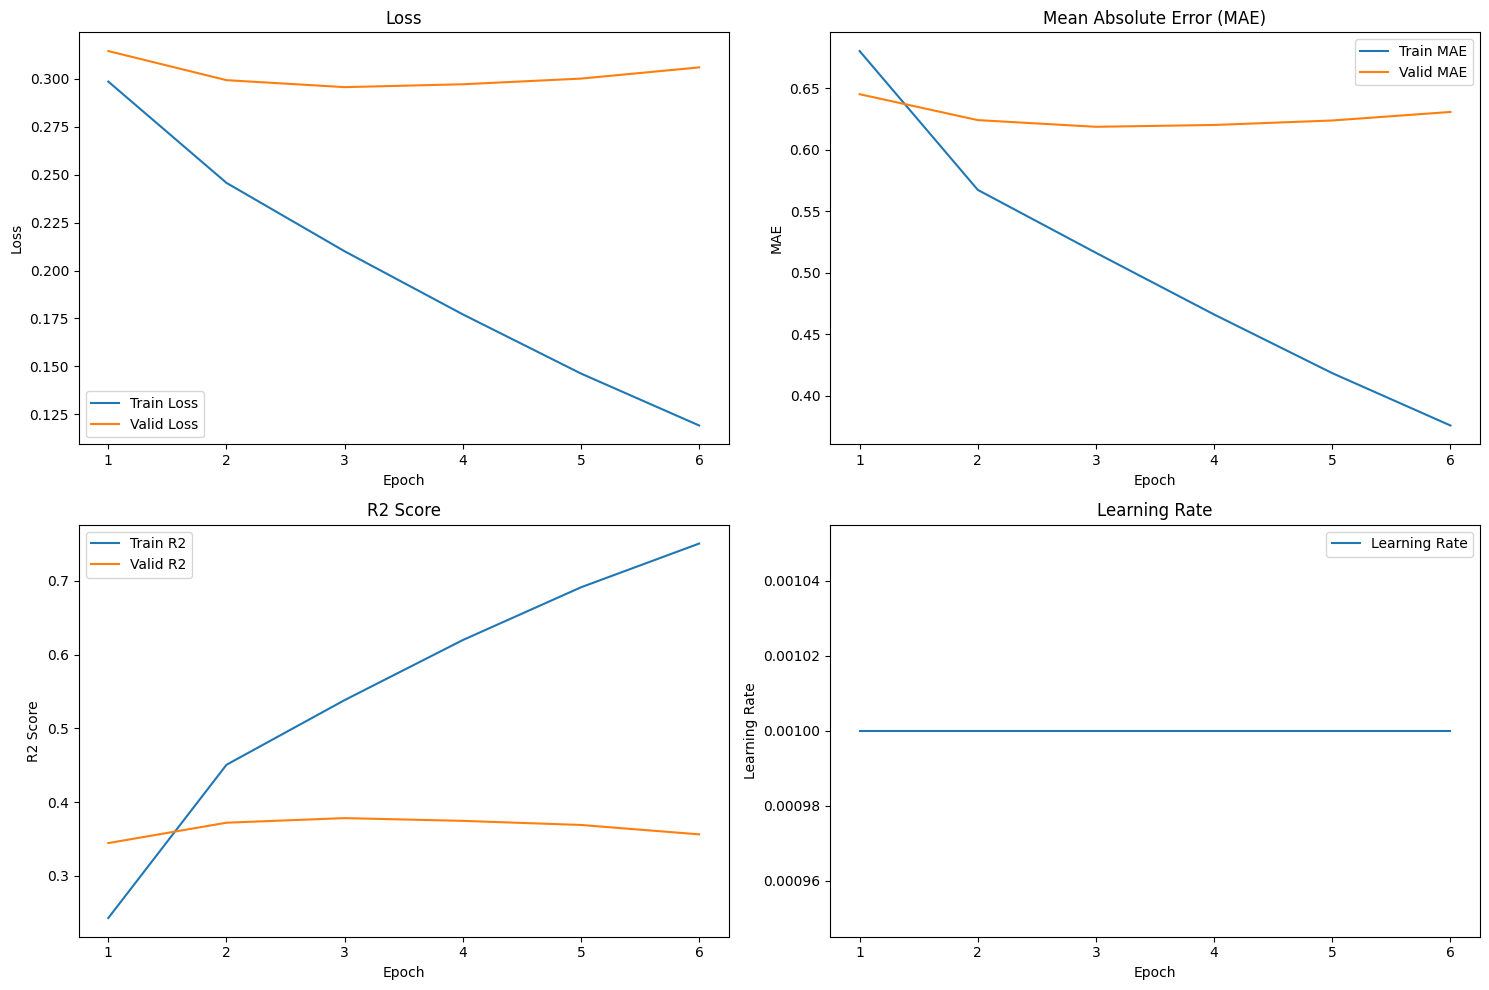

In [10]:
import json
import matplotlib.pyplot as plt

# Load the metrics
with open('metrics6.json', 'r') as f:
    metrics = json.load(f)

# Plotting training and validation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(metrics['epoch'], metrics['loss'], label='Train Loss')
axes[0, 0].plot(metrics['epoch'], metrics['valid_loss'], label='Valid Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# MAE plot
axes[0, 1].plot(metrics['epoch'], metrics['mae'], label='Train MAE')
axes[0, 1].plot(metrics['epoch'], metrics['valid_mae'], label='Valid MAE')
axes[0, 1].set_title('Mean Absolute Error (MAE)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()

# R2 plot
axes[1, 0].plot(metrics['epoch'], metrics['r2'], label='Train R2')
axes[1, 0].plot(metrics['epoch'], metrics['valid_r2'], label='Valid R2')
axes[1, 0].set_title('R2 Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('R2 Score')
axes[1, 0].legend()

# Learning rate plot
axes[1, 1].plot(metrics['epoch'], metrics['lr'], label='Learning Rate')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Predict on test set
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
        y_pred = model(X_sample_test.unsqueeze(0).to('cuda')).detach().cpu().numpy()
    
    y_pred = SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
        if k in LOG_FEATURES:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)
print("Submit!")

  0%|          | 0/6545 [00:00<?, ?it/s]

          id        X4        X11       X18       X50        X26        X3112
0  201238668  0.574741  13.061822  0.891555  1.398243   2.630833   658.911598
1  202310319  0.611227  16.326277  0.467784  1.221367   0.068024  1029.889052
2  202604412  0.678519  12.209492  1.650025  1.677519  26.079254   326.537947
3  201353439  0.540188  22.989200  0.143716  1.018501   0.592939  1264.886323
4  195351745  0.432985  14.820478  0.135452  1.303521   0.199193   164.750838
Submit!
